In [0]:
!pip install catboost==0.20.2

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
import scipy.stats as st
%matplotlib inline
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [0]:
#Now let's import and put the train and test datasets in  pandas dataframe

#train = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_train.csv')
#test = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_train.csv')
#valid = pd.read_csv("/content/real_result_20perc.csv")


df1 = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_train.csv')
df2 = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_test.csv')
valid = pd.read_csv("/content/drive/My Drive/FACO/PDDA_COMPETITION/real_result_20perc.csv")

In [0]:
# remove all rows that contains missing value
df1.replace(['-999', -999], np.nan, inplace=True)


df2.replace(['-999', -999], np.nan, inplace=True)


# LGBM DTS Prediction (RMSE of 23.4)

### Feature Engr Part

In [0]:
gr_denom = df1.GR.max() - df1.GR.min()
df1['V_sh'] = (df1.GR - df1.GR.min())/ gr_denom

Saltwater_desnsity = 2.032
Salt_ft = 1.1
por_denom = Saltwater_desnsity - Salt_ft
df1['Por_est1'] = (Saltwater_desnsity - df1.ZDEN) / por_denom

Por_Factor = ( (df1.CNC ** 2) + (df1.ZDEN ** 2) ) / 2
df1['Por_est2'] = np.sqrt(Por_Factor)

df1['GZB'] = df1.ZDEN - df1.CNC

Hydrogen_mass = 1.00784
df1['Proton'] = Hydrogen_mass - df1.CNC

water_factor = ( df1.HRM / df1.HRD )
root = (1 / df1.CNC)
df1['Water_Sat'] = (water_factor ** root)



In [0]:
valid1 = valid 

#V_SH
gr_denom = df1.GR.max() - df1.GR.min()
valid1['V_sh'] = (valid1.GR - df1.GR.min())/ gr_denom

#Porosity_Estimate1
Saltwater_desnsity = 2.032
Salt_ft = 1.1
por_denom = Saltwater_desnsity - Salt_ft
valid1['Por_est1'] = (Saltwater_desnsity - valid1.ZDEN) / por_denom

#Porosity_Estimate
Por_Factor = ( (valid.CNC ** 2) + (valid1.ZDEN ** 2) ) / 2
valid1['Por_est2'] = np.sqrt(Por_Factor)


#Gas_Zone_Boundry
valid1['GZB'] = valid1.ZDEN - valid1.CNC

#Proton_Reading
Hydrogen_mass = 1.00784
valid1['Proton'] = Hydrogen_mass - valid1.CNC

#Water_Saturation_Level
water_factor = ( valid1.HRM / valid1.HRD )
root = (1 / valid1.CNC)
valid1['Water_Sat'] = (water_factor ** root)

#### Dropping Null values for training

In [0]:
df = df1.dropna()

In [0]:
train = df.drop(['DTC'],axis=1)
train['CNC'] = np.where((train.CNC >= 0.7),0.7,train.CNC)
train['HRM'] = np.where((train.HRM >= 10),10,train.HRM)
train['HRD'] = np.where((train.HRD >= 10),10,train.HRD)
train['GR'] = np.where((train.GR >= 150),150,train.GR)

In [0]:
valid1['CNC'] = np.where((valid1.CNC >= 0.7),0.7,valid1.CNC)
valid1['HRM'] = np.where((valid1.HRM >= 10),10,valid1.HRM)
valid1['HRD'] = np.where((valid1.HRD >= 10),10,valid1.HRD)
valid1['GR'] = np.where((valid1.GR >= 150),150,valid1.GR)

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
import scipy.stats as st
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from scipy.special import boxcox1p


%matplotlib inline
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)


In [0]:
train_x = train.drop(['DTS','V_sh','Por_est1','Por_est2','GZB','Proton',],axis=1)
train_y = train['DTS']
params = {"max_depth": [5,10, 15],
         "learning_rate": [0.01, 0.05, 0.1,],
         "n_estimators": [100, 250,300,500,1000]}
params_cb = {'depth': [5, 10, 15],
            'learning_rate': [0.01, 0.05, 0.1],
            'iterations': [100, 250]}
test_y = valid['DTS']
test_x = valid1.drop(['DTC', 'DTS','V_sh','Por_est1','Por_est2','GZB','Proton',], axis=1)
n_splits = 5
max_train_size = len(train_x) // (n_splits+1)

In [0]:
%%time
model_lg = lgbm.LGBMRegressor()
grid_search_lg = GridSearchCV(model_lg, param_grid=params, cv=TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size), verbose=1, n_jobs=-1)
grid_search_lg.fit(train_x, train_y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min


CPU times: user 1.66 s, sys: 121 ms, total: 1.78 s
Wall time: 1min 52s


[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  1.9min finished


In [0]:
predict_DTS_lg1 = grid_search_lg.predict(test_x)
print('LightGBM RMSE Score: {}'.format(math.sqrt(mean_squared_error(test_y, predict_DTS_lg1))))
print("BEST PARAMETERS: " + str(grid_search_lg.best_params_))

LightGBM RMSE Score: 23.463127689180713
BEST PARAMETERS: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


# Xgboost DTS Prediction (RMSE 23.7)

In [0]:
train = df1.drop(['DTC'],axis=1)
train1 = df1.drop(['DTC'],axis=1)
train1 = train1.dropna()
train = train1
train.describe()

In [0]:

train['CNC'] = np.where((train.CNC >= 0.7),0.7,train.CNC)
train['HRM'] = np.where((train.HRM >= 10),10,train.HRM)
train['HRD'] = np.where((train.HRD >= 10),10,train.HRD)
train['GR'] = np.where((train.GR >= 200),200,train.GR)

valid1 =valid
valid1['CNC'] = np.where((valid1.CNC >= 0.7),0.7,valid1.CNC)
valid1['HRM'] = np.where((valid1.HRM >= 10),10,valid1.HRM)
valid1['HRD'] = np.where((valid1.HRD >= 10),10,valid1.HRD)
valid1['GR'] = np.where((valid1.GR >= 200),200,valid1.GR)
#V_SH
gr_denom = df1.GR.max() - df1.GR.min()
valid1['V_sh'] = (valid1.GR - df1.GR.min())/ gr_denom

#Porosity_Estimate1
Saltwater_desnsity = 2.032
Salt_ft = 1.1
por_denom = Saltwater_desnsity - Salt_ft
valid1['Por_est1'] = (Saltwater_desnsity - valid1.ZDEN) / por_denom

#Porosity_Estimate
Por_Factor = ( (valid.CNC ** 2) + (valid1.ZDEN ** 2) ) / 2
valid1['Por_est2'] = np.sqrt(Por_Factor)


#Gas_Zone_Boundry
valid1['GZB'] = valid1.ZDEN - valid1.CNC

#Proton_Reading
Hydrogen_mass = 1.00784
valid1['Proton'] = Hydrogen_mass - valid1.CNC

#Water_Saturation_Level
water_factor = ( valid1.HRM / valid1.HRD )
root = (1 / valid1.CNC)
valid1['Water_Sat'] = (water_factor ** root)

In [0]:

X = train.drop('DTS',axis=1)
y = train['DTS']

In [0]:

test = valid1.drop(['DTC','DTS'],axis=1)

In [0]:
dmatrix = xgb.DMatrix(data=X, label=y)

In [0]:
best_xgb_model = xgb.XGBRegressor(colsample_bytree=0.7035,
                 gamma=0.6438,                 
                 learning_rate=0.05,
                 max_depth=18,
                 min_child_weight=19.23,
                 n_estimators=1000,                                                                    
                 subsample=0.8662,
                 seed=1234)

In [0]:
best_xgb_model.fit(X,y)


[11:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7035, gamma=0.6438,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=18, min_child_weight=19.23, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1234, silent=None, subsample=0.8662, verbosity=1)

In [0]:
xg_DTS_preds = best_xgb_model.predict(test)
real_DTS_values = valid['DTS']
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(real_DTS_values, xg_DTS_preds))))

Root Mean Square Error is: 23.73402


# Random Forest DTS Prediction (RMSE 24.3)

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
import scipy.stats as st
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from scipy.special import boxcox1p


%matplotlib inline
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [0]:
X = train.drop(['DTS',],axis=1)
y = train['DTS']
test = valid1.drop(['DTC','DTS',],axis=1)

In [0]:
from sklearn.linear_model import LinearRegression, RidgeCV

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

test= scaler.transform(test)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
# train test split
# please remember to use random_state for all randomization steps, this will ensure we get the same results 
# as yours during the validation phase. 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)


In [0]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [0]:
# Random forest model
RF = RandomForestRegressor(n_estimators=1000, random_state=1234)
RF_best = grid_search(RF, {})

0.9893538196771237


In [0]:
RF_DTS_preds = RF_best.predict(test)
real_DTS_values = valid['DTS']
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(real_DTS_values, RF_DTS_preds))))

Root Mean Square Error is: 24.29142


In [0]:
##result_3 = pd.DataFrame(columns=['DTC','DTS'])
##result_3['DTC'] = xg_DTC_preds
##result_3['DTS'] = predict_DTS_lg1
##result_3

# Catboost DTC Prediction (RMSE 4.29)

In [0]:
#Now let's import and put the train and test datasets in  pandas dataframe

#train = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_train.csv')
#test = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_train.csv')
#valid = pd.read_csv("/content/real_result_20perc.csv")


df1 = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_train.csv')
df2 = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_test.csv')
valid = pd.read_csv("/content/drive/My Drive/FACO/PDDA_COMPETITION/real_result_20perc.csv")

In [0]:

# remove all rows that contains missing value
df1.replace(['-999', -999], np.nan, inplace=True)


df2.replace(['-999', -999], np.nan, inplace=True)


In [0]:


df = df1.dropna()

In [0]:

X=df.drop(['DTC',"DTS",],axis =1)
y = df.DTC

In [0]:

test = valid.drop(['DTC','DTS'],axis=1)

In [0]:
from catboost import CatBoostRegressor
errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
fold=KFold(n_splits=20)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = CatBoostRegressor( n_estimators=500,eval_metric='RMSE',learning_rate=0.2, random_seed= 1234, use_best_model=True,)
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=100,)#erly100
    preds=m2.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    errcb2.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m2.predict(test)
    y_pred_totcb2.append(p2)
np.mean(errcb2)

0:	learn: 18.2176992	test: 18.2176992	test1: 33.2242478	best: 33.2242478 (0)	total: 55.6ms	remaining: 27.8s
100:	learn: 3.0585720	test: 3.0585720	test1: 5.1619225	best: 5.1619225 (100)	total: 643ms	remaining: 2.54s
200:	learn: 2.6546443	test: 2.6546443	test1: 5.4954759	best: 5.1181044 (133)	total: 1.22s	remaining: 1.82s
300:	learn: 2.4011454	test: 2.4011454	test1: 5.7966948	best: 5.1181044 (133)	total: 1.81s	remaining: 1.19s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 5.118104436
bestIteration = 133

Shrink model to first 134 iterations.
err:  5.118104449348533
0:	learn: 18.1427686	test: 18.1427686	test1: 33.9201538	best: 33.9201538 (0)	total: 6.31ms	remaining: 3.15s
100:	learn: 3.0072758	test: 3.0072758	test1: 3.5390574	best: 3.5270374 (88)	total: 576ms	remaining: 2.27s
200:	learn: 2.6080030	test: 2.6080030	test1: 3.4603170	best: 3.4603170 (200)	total: 1.15s	remaining: 1.71s
300:	learn: 2.3726923	test: 2.3726923	test1: 3.5489890	best: 3.4599329 (201)	total: 1.73

4.365247153145564

In [0]:
cat_DTC_preds = np.mean(y_pred_totcb2, 0)

In [0]:
real_DTC_values = valid['DTC']

In [0]:
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(real_DTC_values, cat_DTC_preds))))

Root Mean Square Error is: 4.29563


# Checking Overall Performance on DTC and DTS

In [0]:
results = pd.DataFrame(columns=['DTC','DTS'])

In [0]:
results = pd.DataFrame(columns=['DTC','DTS'])
results['DTC'] = cat_DTC_preds
results['DTS'] = predict_DTS_lg1
results.head()

,DTC,DTS
0,69.019633,125.371344
1,94.704563,170.000599
2,92.904805,180.991461
3,77.862650,147.838979
4,79.660607,137.127097


In [0]:
results_data = np.array(results)

In [0]:
valid_data = np.array(valid)
y_real = valid_data[:,-2:]

In [0]:
 print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, results))))

Root Mean Square Error is: 16.86669


# LGBM DTC Prediction (RMSE 4.34)

In [0]:
gr_denom = df1.GR.max() - df1.GR.min()
df1['V_sh'] = (df1.GR - df1.GR.min())/ gr_denom

Saltwater_desnsity = 2.032
Salt_ft = 1.1
por_denom = Saltwater_desnsity - Salt_ft
df1['Por_est1'] = (Saltwater_desnsity - df1.ZDEN) / por_denom

Por_Factor = ( (df1.CNC ** 2) + (df1.ZDEN ** 2) ) / 2
df1['Por_est2'] = np.sqrt(Por_Factor)

df1['GZB'] = df1.ZDEN - df1.CNC

Hydrogen_mass = 1.00784
df1['Proton'] = Hydrogen_mass - df1.CNC

water_factor = ( df1.HRM / df1.HRD )
root = (1 / df1.CNC)
df1['Water_Sat'] = (water_factor ** root)


valid1 = valid 

#V_SH
gr_denom = df1.GR.max() - df1.GR.min()
valid1['V_sh'] = (valid1.GR - df1.GR.min())/ gr_denom

#Porosity_Estimate1
Saltwater_desnsity = 2.032
Salt_ft = 1.1
por_denom = Saltwater_desnsity - Salt_ft
valid1['Por_est1'] = (Saltwater_desnsity - valid1.ZDEN) / por_denom

#Porosity_Estimate
Por_Factor = ( (valid.CNC ** 2) + (valid1.ZDEN ** 2) ) / 2
valid1['Por_est2'] = np.sqrt(Por_Factor)


#Gas_Zone_Boundry
valid1['GZB'] = valid1.ZDEN - valid1.CNC

#Proton_Reading
Hydrogen_mass = 1.00784
valid1['Proton'] = Hydrogen_mass - valid1.CNC

#Water_Saturation_Level
water_factor = ( valid1.HRM / valid1.HRD )
root = (1 / valid1.CNC)
valid1['Water_Sat'] = (water_factor ** root)


In [0]:
train = df1.drop(['DTS'],axis=1)
train1 = df1.drop(['DTS'],axis=1)
train1['CAL'] = train['CAL'].fillna(train['CAL'].median())
train1['CNC'] = train['CNC'].fillna(train['CNC'].median())
train1['GR'] = train['GR'].fillna(train['GR'].median())
train1['HRD'] = train['HRD'].fillna(train['HRD'].median())
train1['HRM'] = train['HRM'].fillna(train['HRM'].median())
train1['PE'] = train['PE'].fillna(train['PE'].median())
train1['ZDEN'] = train['ZDEN'].fillna(train['ZDEN'].median())
train1 = train1.dropna()

In [0]:
train1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,V_sh,Por_est1,Por_est2,GZB,Proton,Water_Sat
count,25473.000000,25473.000000,25473.000000,25473.000000,25473.000000,25473.000000,25473.000000,25473.000000,25473.000000,25473.000000,25473.000000,25473.000000,25473.000000,2.547300e+04
mean,8.606485,0.758501,46.954938,2.357292,4.970281,4.984346,2.385471,90.990370,0.032033,-0.379261,2.054520,1.626970,0.249339,6.398393e+68
std,1.778152,32.974446,50.310600,3.205608,379.209898,5.012884,0.203632,23.971821,0.034216,0.218489,23.293553,32.976636,32.974446,1.021200e+71
min,5.930400,-0.102800,1.038900,0.123600,0.134100,-0.023200,-1.923800,49.970500,0.000806,-1.317275,0.068801,-3487.918200,-3489.150360,1.451771e-12
25%,6.918600,0.125000,15.653400,0.677300,0.671900,0.052000,2.221900,71.136700,0.010745,-0.559657,1.597856,1.878300,0.638140,8.480401e-01
50%,8.625000,0.210100,37.072100,1.438700,1.435700,4.851100,2.428200,83.541500,0.025312,-0.425107,1.727922,2.176500,0.797740,9.833700e-01
75%,9.033900,0.369700,58.340100,3.117000,3.240000,8.033700,2.553600,110.014300,0.039776,-0.203755,1.809044,2.423200,0.882840,1.318654e+00
max,21.064200,3490.158200,1470.253400,206.718200,60467.761700,28.106400,3.259700,155.980300,1.000000,4.244421,2467.915039,2.960000,1.110640,1.629863e+73


In [0]:
train = train1
train['CNC'] = np.where((train.CNC >= 0.7),0.7,train.CNC)
train['HRM'] = np.where((train.HRM >= 10),10,train.HRM)
train['HRD'] = np.where((train.HRD >= 10),10,train.HRD)
train['GR'] = np.where((train.GR >= 200),200,train.GR)



In [0]:
valid1['CNC'] = np.where((valid1.CNC >= 0.7),0.7,valid1.CNC)
valid1['HRM'] = np.where((valid1.HRM >= 10),10,valid1.HRM)
valid1['HRD'] = np.where((valid1.HRD >= 10),10,valid1.HRD)
valid1['GR'] = np.where((valid1.GR >= 200),200,valid1.GR)

In [0]:
valid1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,V_sh,Por_est1,Por_est2,GZB,Proton,Water_Sat
count,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2.217000e+03
mean,8.634826,0.158620,28.523672,3.427507,3.773550,7.360546,2.476402,76.716787,145.373654,0.020627,-0.476826,1.756067,2.317782,0.849220,1.135490e+32
std,0.044438,0.090789,31.099853,2.498131,2.672341,1.255721,0.150628,14.257791,44.345398,0.033972,0.161618,0.102749,0.222581,0.090789,5.331606e+33
min,8.500000,0.009800,1.235100,0.086100,0.154800,4.780900,2.033400,53.164700,86.306500,0.000939,-1.046030,1.488287,1.490000,0.464440,3.484456e-03
25%,8.625000,0.092000,8.535300,1.770200,1.857600,6.526200,2.377200,66.169800,119.515300,0.005904,-0.590665,1.697179,2.151700,0.793640,1.134011e+00
50%,8.625000,0.128900,19.375200,2.772100,3.197000,7.881300,2.535500,71.417900,130.290800,0.013276,-0.540236,1.795367,2.398700,0.878940,2.088489e+00
75%,8.671900,0.214200,37.201300,4.511500,5.029100,8.308300,2.582500,85.807000,146.235700,0.025399,-0.370386,1.827659,2.487200,0.915840,3.898914e+00
max,8.781300,0.543400,200.000000,10.000000,10.000000,13.741000,3.006900,120.351200,342.425400,0.680793,-0.001502,2.149565,2.685700,0.998040,2.510382e+35


In [0]:
#train = df.drop(['DTC'],axis=1)
train_x = train.drop(['DTC','V_sh','Por_est1','Por_est2','GZB','Proton'],axis=1)
train_y = train['DTC']
params = {"max_depth": [5,10, 15,20],
         "learning_rate": [0.01, 0.05, 0.1],
         "n_estimators": [100, 250,300,500,1000,]}
params_cb = {'depth': [5, 10, 15],
            'learning_rate': [0.01, 0.05, 0.1],
            'iterations': [100, 250]}
test_y = valid['DTC']
test_x = valid1.drop(['DTC', 'DTS','V_sh','Por_est1','Por_est2','GZB','Proton'], axis=1)
n_splits = 5
max_train_size = len(train_x) // (n_splits+1)

In [0]:
%%time
model_lg = lgbm.LGBMRegressor()
grid_search_lg = GridSearchCV(model_lg, param_grid=params, cv=TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size), verbose=1, n_jobs=-1)
grid_search_lg.fit(train_x, train_y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


CPU times: user 2.1 s, sys: 221 ms, total: 2.32 s
Wall time: 2min 52s


In [0]:
predict_DTC_lg = grid_search_lg.predict(test_x)
print('LightGBM RMSE Score: {}'.format(math.sqrt(mean_squared_error(test_y, predict_DTC_lg))))
print("BEST PARAMETERS: " + str(grid_search_lg.best_params_))

LightGBM RMSE Score: 4.342831624802041
BEST PARAMETERS: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


# Xgboost DTC Prediction (RMSE 4.57)


In [0]:
train = df1.drop(['DTS'],axis=1)
train1 = df1.drop(['DTS'],axis=1)
train1 = train1.dropna()
train = train1
train.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,V_sh,Por_est1,Por_est2,GZB,Proton,Water_Sat
count,25094.000000,25094.000000,25094.000000,25094.000000,25094.000000,25094.000000,25094.000000,25094.000000,25094.000000,25094.000000,25094.000000,25094.000000,25094.000000,2.509400e+04
mean,8.606205,0.760769,47.467037,2.341245,4.992888,4.964889,2.383512,91.302222,0.032381,-0.377159,2.053866,1.622743,0.247071,6.495029e+68
std,1.791528,33.218267,50.514405,3.221464,382.062826,5.047031,0.203682,24.009869,0.034354,0.218543,23.466123,33.220459,33.218267,1.028883e+71
min,5.930400,-0.102800,1.038900,0.123600,0.134100,-0.023200,-1.923800,49.970500,0.000806,-1.317275,0.068801,-3487.918200,-3489.150360,1.451771e-12
25%,6.891325,0.125900,16.873900,0.672100,0.665800,0.051800,2.220200,71.312275,0.011575,-0.558691,1.596990,1.873600,0.634065,8.462831e-01
50%,8.609650,0.213900,37.573700,1.391250,1.396100,4.766250,2.422500,84.617050,0.025653,-0.418991,1.724141,2.167250,0.793940,9.830523e-01
75%,9.044975,0.373775,58.613325,3.095175,3.215800,8.080425,2.552700,110.513975,0.039961,-0.201931,1.808390,2.421575,0.881940,1.318545e+00
max,21.064200,3490.158200,1470.253400,206.718200,60467.761700,28.106400,3.259700,155.980300,1.000000,4.244421,2467.915039,2.960000,1.110640,1.629863e+73


In [0]:
train['CNC'] = np.where((train.CNC >= 0.7),0.7,train.CNC)
train['HRM'] = np.where((train.HRM >= 10),10,train.HRM)
train['HRD'] = np.where((train.HRD >= 10),10,train.HRD)
train['GR'] = np.where((train.GR >= 200),200,train.GR)

valid1 =valid
valid1['CNC'] = np.where((valid1.CNC >= 0.7),0.7,valid1.CNC)
valid1['HRM'] = np.where((valid1.HRM >= 10),10,valid1.HRM)
valid1['HRD'] = np.where((valid1.HRD >= 10),10,valid1.HRD)
valid1['GR'] = np.where((valid1.GR >= 200),200,valid1.GR)
#V_SH
gr_denom = df1.GR.max() - df1.GR.min()
valid1['V_sh'] = (valid1.GR - df1.GR.min())/ gr_denom

#Porosity_Estimate1
Saltwater_desnsity = 2.032
Salt_ft = 1.1
por_denom = Saltwater_desnsity - Salt_ft
valid1['Por_est1'] = (Saltwater_desnsity - valid1.ZDEN) / por_denom

#Porosity_Estimate
Por_Factor = ( (valid.CNC ** 2) + (valid1.ZDEN ** 2) ) / 2
valid1['Por_est2'] = np.sqrt(Por_Factor)


#Gas_Zone_Boundry
valid1['GZB'] = valid1.ZDEN - valid1.CNC

#Proton_Reading
Hydrogen_mass = 1.00784
valid1['Proton'] = Hydrogen_mass - valid1.CNC

#Water_Saturation_Level
water_factor = ( valid1.HRM / valid1.HRD )
root = (1 / valid1.CNC)
valid1['Water_Sat'] = (water_factor ** root)



In [0]:

X = train.drop('DTC',axis=1)
y = train['DTC']

dmatrix = xgb.DMatrix(data=X, label=y)

best_xgb_model = xgb.XGBRegressor(colsample_bytree=0.7035,
                 gamma=0.6438,                 
                 learning_rate=0.05,
                 max_depth=18,
                 min_child_weight=19.23,
                 n_estimators=1000,                                                                    
                 subsample=0.8662,
                 seed=1234)

In [0]:
test = valid1.drop(['DTC','DTS'],axis=1)

In [0]:
best_xgb_model.fit(X,y)

[05:43:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7035, gamma=0.6438,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=18, min_child_weight=19.23, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1234, silent=None, subsample=0.8662, verbosity=1)

In [0]:

xg_DTC_preds = best_xgb_model.predict(test)
real_DTC_values = valid['DTC']
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(real_DTC_values, xg_DTC_preds))))

Root Mean Square Error is: 4.57092


#KERAS

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
import scipy.stats as st
%matplotlib inline
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [0]:
import keras
from keras import models, layers, regularizers

Using TensorFlow backend.


# Original PDDA DATA without Feature Engr

In [0]:
#Now let's import and put the train and test datasets in  pandas dataframe

#train = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_train.csv')
#test = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_train.csv')
#valid = pd.read_csv("/content/real_result_20perc.csv")


df1 = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_train.csv')
df2 = pd.read_csv('/content/drive/My Drive/FACO/PDDA_COMPETITION/pdda_test.csv')
valid = pd.read_csv("/content/drive/My Drive/FACO/PDDA_COMPETITION/real_result_20perc.csv")
# remove all rows that contains missing value
df1.replace(['-999', -999], np.nan, inplace=True)


df2.replace(['-999', -999], np.nan, inplace=True)


df = df1.dropna()
X=df.drop(['DTC',"DTS",],axis =1)
y = df.DTS
valid_x = valid.drop(['DTC','DTS'],axis=1)
valid_y = valid.DTS

# Data With Feature Engr for DTS Prediction

#### Don't run the next set of codes if you don't wish to train with feature engineered data

In [0]:


gr_denom = df1.GR.max() - df1.GR.min()
df1['V_sh'] = (df1.GR - df1.GR.min())/ gr_denom

Saltwater_desnsity = 2.032
Salt_ft = 1.1
por_denom = Saltwater_desnsity - Salt_ft
df1['Por_est1'] = (Saltwater_desnsity - df1.ZDEN) / por_denom

Por_Factor = ( (df1.CNC ** 2) + (df1.ZDEN ** 2) ) / 2
df1['Por_est2'] = np.sqrt(Por_Factor)

df1['GZB'] = df1.ZDEN - df1.CNC

Hydrogen_mass = 1.00784
df1['Proton'] = Hydrogen_mass - df1.CNC

water_factor = ( df1.HRM / df1.HRD )
root = (1 / df1.CNC)
df1['Water_Sat'] = (water_factor ** root)


valid1 = valid 


#V_SH
gr_denom = df1.GR.max() - df1.GR.min()
valid1['V_sh'] = (valid1.GR - df1.GR.min())/ gr_denom

#Porosity_Estimate1
Saltwater_desnsity = 2.032
Salt_ft = 1.1
por_denom = Saltwater_desnsity - Salt_ft
valid1['Por_est1'] = (Saltwater_desnsity - valid1.ZDEN) / por_denom

#Porosity_Estimate
Por_Factor = ( (valid.CNC ** 2) + (valid1.ZDEN ** 2) ) / 2
valid1['Por_est2'] = np.sqrt(Por_Factor)


#Gas_Zone_Boundry
valid1['GZB'] = valid1.ZDEN - valid1.CNC

#Proton_Reading
Hydrogen_mass = 1.00784
valid1['Proton'] = Hydrogen_mass - valid1.CNC

#Water_Saturation_Level
water_factor = ( valid1.HRM / valid1.HRD )
root = (1 / valid1.CNC)
valid1['Water_Sat'] = (water_factor ** root)


In [0]:
train1 = df1.drop(['DTC'],axis=1)
train1 = train1.dropna()
train = train1
train.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTS,V_sh,Por_est1,Por_est2,GZB,Proton,Water_Sat
count,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,2.436800e+04
mean,8.466867,0.262133,50.581637,20.403694,17.354255,4.213471,2.416301,177.757594,0.034499,-0.412340,1.739782,2.154168,0.745707,6.688536e+68
std,1.709879,2.811018,55.800269,385.662106,492.109905,4.225689,0.175008,79.439635,0.037949,0.187777,1.973067,2.826087,2.811018,1.044097e+71
min,5.930400,0.014500,-0.146000,0.054100,0.061600,-0.023200,0.680600,80.580400,0.000000,-1.317275,0.510020,-363.753400,-364.877160,2.684239e-26
25%,6.847725,0.122900,18.002225,0.864900,0.850175,0.051500,2.249500,128.715025,0.012342,-0.568240,1.615097,1.971275,0.700515,8.134476e-01
50%,8.578100,0.183600,37.464500,1.928550,1.924900,4.421850,2.466400,143.236800,0.025578,-0.466094,1.753047,2.257100,0.824240,9.766534e-01
75%,8.687500,0.307325,61.499625,3.448500,3.546700,7.134250,2.561600,189.121925,0.041924,-0.233369,1.813969,2.432525,0.884940,1.338351e+00
max,21.064200,365.885000,1470.253400,10000.000000,60467.761700,28.106400,3.259700,487.438400,1.000000,1.450000,258.724155,2.960000,0.993340,1.629863e+73


In [0]:
train['CNC'] = np.where((train.CNC >= 0.7),0.7,train.CNC)
train['HRM'] = np.where((train.HRM >= 10),10,train.HRM)
train['HRD'] = np.where((train.HRD >= 10),10,train.HRD)
train['GR'] = np.where((train.GR >= 200),200,train.GR)

valid1 =valid
valid1['CNC'] = np.where((valid1.CNC >= 0.7),0.7,valid1.CNC)
valid1['HRM'] = np.where((valid1.HRM >= 10),10,valid1.HRM)
valid1['HRD'] = np.where((valid1.HRD >= 10),10,valid1.HRD)
valid1['GR'] = np.where((valid1.GR >= 200),200,valid1.GR)

In [0]:
train.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTS
count,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000,24368.000000
mean,8.466867,0.234119,48.193424,2.655235,2.687779,4.213471,2.416301,177.757594
std,1.709879,0.152336,42.054034,2.438592,2.447487,4.225689,0.175008,79.439635
min,5.930400,0.014500,-0.146000,0.054100,0.061600,-0.023200,0.680600,80.580400
25%,6.847725,0.122900,18.002225,0.864900,0.850175,0.051500,2.249500,128.715025
50%,8.578100,0.183600,37.464500,1.928550,1.924900,4.421850,2.466400,143.236800
75%,8.687500,0.307325,61.499625,3.448500,3.546700,7.134250,2.561600,189.121925
max,21.064200,0.700000,200.000000,10.000000,10.000000,28.106400,3.259700,487.438400


In [0]:
valid1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000
mean,8.634826,0.158620,28.523672,3.427507,3.773550,7.360546,2.476402,76.716787,145.373654
std,0.044438,0.090789,31.099853,2.498131,2.672341,1.255721,0.150628,14.257791,44.345398
min,8.500000,0.009800,1.235100,0.086100,0.154800,4.780900,2.033400,53.164700,86.306500
25%,8.625000,0.092000,8.535300,1.770200,1.857600,6.526200,2.377200,66.169800,119.515300
50%,8.625000,0.128900,19.375200,2.772100,3.197000,7.881300,2.535500,71.417900,130.290800
75%,8.671900,0.214200,37.201300,4.511500,5.029100,8.308300,2.582500,85.807000,146.235700
max,8.781300,0.543400,200.000000,10.000000,10.000000,13.741000,3.006900,120.351200,342.425400


In [0]:
X = train.drop(['DTS'],axis=1)
y = train.DTS
valid_x = valid1.drop(['DTS','DTC'],axis=1)
valid_y = valid1.DTS

# Training Part

In [0]:
 
# ANN with Keras
np.random.seed(10)

model = models.Sequential()
model.add(layers.Dense(256, activation='tanh', input_shape=(X.shape[1],)))
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(1))
    
optimizer = keras.optimizers.RMSprop(0.001)
    
model.compile(optimizer=optimizer,
              loss='mae',
              metrics=['mae', 'mse'])

              


In [63]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 68,097
Trainable params: 68,097
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X, y,

                   epochs=200,
                   batch_size=5,
                   validation_data=(valid_x, valid_y))


Train on 24368 samples, validate on 2217 samples
Epoch 1/200
24368/24368 [==============================] - 7s 300us/step - loss: 21.4954 - mae: 21.4954 - mse: 1263.1732 - val_loss: 28.7797 - val_mae: 28.7797 - val_mse: 1226.2279
Epoch 2/200
24368/24368 [==============================] - 7s 285us/step - loss: 15.5080 - mae: 15.5080 - mse: 590.2552 - val_loss: 23.9232 - val_mae: 23.9232 - val_mse: 952.6151
Epoch 3/200
24368/24368 [==============================] - 7s 293us/step - loss: 14.4502 - mae: 14.4503 - mse: 537.6110 - val_loss: 18.8252 - val_mae: 18.8253 - val_mse: 791.0334
Epoch 4/200
24368/24368 [==============================] - 7s 292us/step - loss: 13.7751 - mae: 13.7751 - mse: 491.3591 - val_loss: 28.5717 - val_mae: 28.5717 - val_mse: 1145.6724
Epoch 5/200
24368/24368 [==============================] - 7s 293us/step - loss: 13.3730 - mae: 13.3730 - mse: 468.3517 - val_loss: 22.4358 - val_mae: 22.4358 - val_mse: 873.2426
Epoch 6/200
24368/24368 [============================

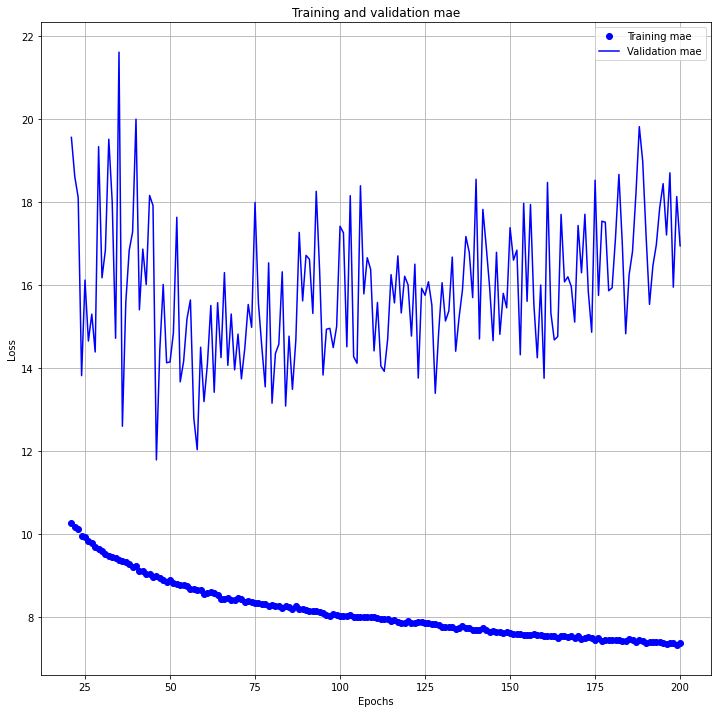

In [0]:
import matplotlib.pyplot as plt

mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(mae) + 1)

plt.figure(figsize=(12, 12))
plt.plot(epochs[20:], mae[20:], 'bo', label='Training mae')
plt.plot(epochs[20:], val_mae[20:], 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [0]:
y_pred = model.predict(X_test)

print('-' * 10 + 'NN' + '-' * 10)
print('R square Accuracy: ', r2_score(y_test, y_pred))
print('Mean Absolute Error: ', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))

In [0]:
X = train.drop(['DTS'],axis=1)
y = train.DTS
valid_x = valid1.drop(['DTS','DTC'],axis=1)
valid_y = valid1.DTS

In [0]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X.shape[1],)))
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1))
    
optimizer = keras.optimizers.RMSprop(0.001)
    
model.compile(optimizer=optimizer,
              loss='mae',
              metrics=['mae', 'mse'])

# Didi you fit on validation data too

In [0]:
history = model.fit(X, y,
                   epochs=300,
                   batch_size=5,
                   validation_split=0.1)


Train on 18472 samples, validate on 2053 samples
Epoch 1/300
18472/18472 [==============================] - 10s 531us/step - loss: 38.6882 - mae: 38.6883 - mse: 5304.7207 - val_loss: 18.8177 - val_mae: 18.8177 - val_mse: 449.2320
Epoch 2/300
18472/18472 [==============================] - 14s 734us/step - loss: 14.0989 - mae: 14.0989 - mse: 609.5432 - val_loss: 28.1153 - val_mae: 28.1153 - val_mse: 938.9786
Epoch 3/300
18472/18472 [==============================] - 16s 893us/step - loss: 11.4282 - mae: 11.4282 - mse: 402.5117 - val_loss: 22.1939 - val_mae: 22.1939 - val_mse: 605.6442
Epoch 4/300
18472/18472 [==============================] - 12s 672us/step - loss: 10.4018 - mae: 10.4018 - mse: 346.7397 - val_loss: 26.6893 - val_mae: 26.6893 - val_mse: 881.1924
Epoch 5/300
18472/18472 [==============================] - 10s 532us/step - loss: 9.8594 - mae: 9.8594 - mse: 307.0314 - val_loss: 34.9322 - val_mae: 34.9322 - val_mse: 1395.3710
Epoch 6/300
18472/18472 [==========================

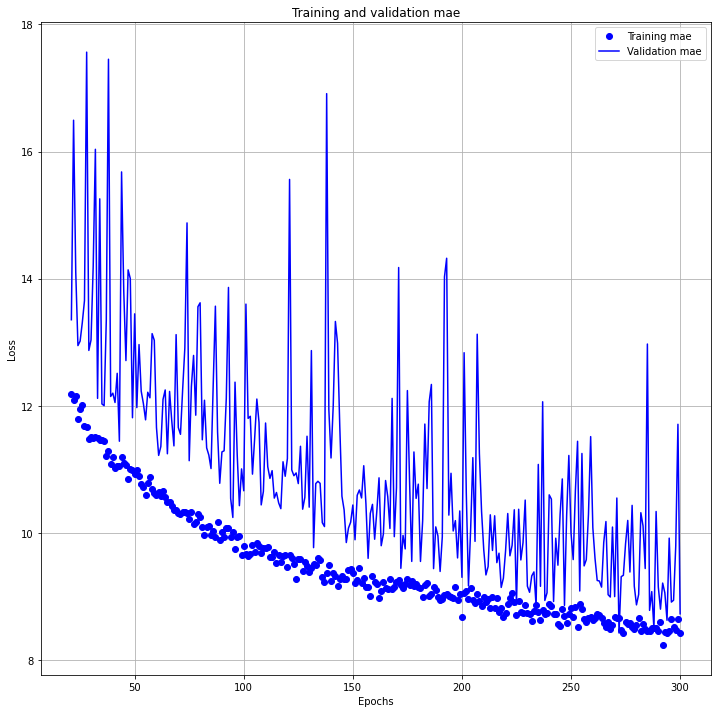

In [0]:
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(mae) + 1)

plt.figure(figsize=(12, 12))
plt.plot(epochs[20:], mae[20:], 'bo', label='Training mae')
plt.plot(epochs[20:], val_mae[20:], 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
y_pred_model = model.predict(valid_x)

In [0]:
X = train.drop(['DTS'],axis=1)
y = train.DTS
valid_x = valid1.drop(['DTS','DTC'],axis=1)
valid_y = valid1.DTS

In [57]:
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(valid_y, y_pred_model))))

ValueError: ignored

In [0]:
model_pred = []

for pred in range(len(y_pred_model.tolist())):
    model_pred.append(y_pred_model.tolist()[pred][0])

In [0]:
print(y_pred_model)

[[125.924324]
 [198.38321 ]
 [236.02283 ]
 ...
 [170.08557 ]
 [111.94314 ]
 [130.60135 ]]


In [0]:
model_pred[:10]

[125.92432403564453,
 198.38320922851562,
 236.0228271484375,
 145.86087036132812,
 138.0303955078125,
 186.76119995117188,
 121.50055694580078,
 147.51101684570312,
 128.50466918945312,
 119.00751495361328]

# Getting DTS prediction on final Test Data

In [0]:
df2.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800
max,8.875000,0.559400,1124.442000,202.233000,62290.769500,13.840700,3.024800


In [0]:
final_dts_preds = model.predict(df2)

In [0]:
dts_model_pred = []

for pred in range(len(final_dts_preds.tolist())):
    dts_model_pred.append(final_dts_preds.tolist()[pred][0])

In [0]:
print(dts_model_pred)

[264.2587585449219, 264.2273864746094, 260.1526184082031, 258.6592102050781, 258.7010192871094, 256.23614501953125, 240.7578125, 225.05746459960938, 222.15737915039062, 221.72573852539062, 231.74774169921875, 258.4653015136719, 258.5892028808594, 260.73406982421875, 259.2806701660156, 255.78466796875, 254.62115478515625, 255.4503173828125, 257.9012145996094, 257.7388000488281, 256.244873046875, 252.45156860351562, 254.999755859375, 258.15118408203125, 259.5489196777344, 258.2358093261719, 258.0146179199219, 254.93356323242188, 246.22732543945312, 235.2982177734375, 235.052490234375, 262.921630859375, 259.2223815917969, 257.73004150390625, 256.2315368652344, 253.295654296875, 254.16729736328125, 254.00091552734375, 254.70303344726562, 254.64752197265625, 258.0984191894531, 256.6833801269531, 255.95797729492188, 260.00543212890625, 264.8758850097656, 268.5970764160156, 264.5553894042969, 259.7926940917969, 258.1729431152344, 258.1368103027344, 239.11093139648438, 203.82455444335938, 180.

In [0]:
results = pd.DataFrame(columns=['DTC','DTS'])

In [0]:
results['DTS'] = dts_model_pred

In [0]:
results.head()

,DTC,DTS
0,NaN,264.258759
1,NaN,264.227386
2,NaN,260.152618
3,NaN,258.659210
4,NaN,258.701019


In [0]:
sub = pd.DataFrame()
##sub['DTC'] = DTC
sub['DTS'] = DTS
sub.to_csv('submission_NN_300420.csv',index=False)

In [0]:
model_pred = np.array(model_pred)
model_pred

In [0]:
final_blend = ensemble * 0.5 + model_pred * 0.5

In [0]:
sub = pd.DataFrame()
sub['DTC'] = test_ID
sub['DTS'] = final_blend
sub.to_csv('Team_Triumphant_submission_3.csv',index=False)

##Stacking models


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [0]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [0]:
averaged_models = AveragingModels(models = (model_lg, best_xgb_model, m2))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: ignored

In [0]:
---LGBM DTS
predict_DTS_lg1 = grid_search_lg.predict(test_x)
print('LightGBM RMSE Score: {}'.format(math.sqrt(mean_squared_error(test_y, predict_DTS_lg1))))
print("BEST PARAMETERS: " + str(grid_search_lg.best_params_))
----LGBM DTC
predict_DTC_lg = grid_search_lg.predict(test_x)
print('LightGBM RMSE Score: {}'.format(math.sqrt(mean_squared_error(test_y, predict_DTC_lg))))
print("BEST PARAMETERS: " + str(grid_search_lg.best_params_))
------XGBOOST DTS
xg_DTS_preds = best_xgb_model.predict(test)
real_DTS_values = valid['DTS']
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(real_DTS_values, xg_DTS_preds))))
------XGBOOST DTC
xg_DTC_preds = best_xgb_model.predict(test)
real_DTC_values = valid['DTC']
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(real_DTC_values, xg_DTC_preds))))
----RANDOM FOREST DTS
RF_DTS_preds = RF_best.predict(test)
real_DTS_values = valid['DTS']
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(real_DTS_values, RF_DTS_preds))))

---CATBOOST DTC
cat_DTC_preds = np.mean(y_pred_totcb2, 0)
real_DTC_values = valid['DTC']
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(real_DTC_values, cat_DTC_preds))))

In [0]:
result2 = pd.DataFrame(columns=['DTC','DTS'])
result2['DTC'] = predict_DTC_lg
result2['DTS'] = predict_DTS_lg1
result2.head()

,DTC,DTS
0,67.994818,125.371344
1,92.990301,170.000599
2,93.620436,180.991461
3,76.393335,147.838979
4,82.943467,137.127097
